In [16]:
%pip install rastervision==0.31
%pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1
%pip install rasterio==1.4.0
%pip install gdown
%pip install utils

Note: you may need to restart the kernel to use updated packages.
  Using cached rasterio-1.4.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
Using cached rasterio-1.4.0-cp312-cp312-win_amd64.whl (25.3 MB)
  Attempting uninstall: rasterio
    Found existing installation: rasterio 1.3.11
    Uninstalling rasterio-1.3.11:
      Successfully uninstalled rasterio-1.3.11
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
  You can safely remove it manually.


In [1]:
import os
import subprocess
import rastervision
import rasterio
from subprocess import check_output
# os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()
# os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'


# Get the location of rasterio
rasterio_location = check_output('pip show rasterio', shell=True).decode()

# Find the line that specifies the location
gdal_data_path = None
for line in rasterio_location.splitlines():
    if line.startswith("Location:"):
        gdal_data_path = os.path.join(line.split(":", 1)[1].strip(), 'rasterio', 'gdal_data')
        break

# Set the GDAL_DATA environment variable if we found the path
if gdal_data_path:
    os.environ['GDAL_DATA'] = gdal_data_path
    print(f"GDAL_DATA has been set to: {gdal_data_path}")
else:
    print("Could not find the GDAL data path.")


GDAL_DATA has been set to: C:\Users\oltie\anaconda3\envs\test\Lib\site-packages\rasterio\gdal_data


In [3]:
# from storage_import import download_blob_from_azure
# # Define el nombre del archivo y el directorio de descarga
# file_name = "train;img;LaMatanza_GE.tif"
# output_dir = "custom_data_folder"  # Puedes definir cualquier ruta de directorio que prefieras

# # Llamar a la función de descarga
# download_blob_from_azure(file_name, output_dir)

In [2]:
import gdown
import glob
import utils

from rastervision.core.data import RasterioSource, MinMaxTransformer

from rastervision.core.data import (
    ClassConfig, GeoJSONVectorSource, RasterioCRSTransformer,
    RasterizedSource, ClassInferenceTransformer)

from rastervision.core.data import SemanticSegmentationLabelSource

from rastervision.core.data.utils.geojson import get_polygons_from_uris
from shapely.geometry import Polygon

from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset, SemanticSegmentationSlidingWindowGeoDataset, SemanticSegmentationVisualizer)

import albumentations as A

import torch
from torch.utils.data import ConcatDataset

from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationLearner



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\oltie\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\oltie\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\oltie\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

In [5]:
import random
import numpy as np
import torch

# Set global seed for reproducibility
def set_global_seed(seed):
    random.seed(seed)  # Python's random module
    np.random.seed(seed)  # NumPy's random module
    torch.manual_seed(seed)  # PyTorch seed for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # PyTorch seed for current GPU
        torch.cuda.manual_seed_all(seed)  # PyTorch seed for all GPUs (if using multi-GPU)

# Prepare cuDNN for deterministic behavior
def prepare_cudnn(deterministic=True):
    torch.backends.cudnn.deterministic = deterministic  # cuDNN deterministic setting
    torch.backends.cudnn.benchmark = not deterministic  # Disable cuDNN benchmarking if deterministic

# Set the seed and configure cuDNN
SEED = 42
set_global_seed(SEED)
prepare_cudnn(deterministic=True)


In [6]:
images_val = "./data/img/2021.tif"
annotations_val = "./data/labels/barrios_3dfeb_lamtz.geojson"
images_train ="./data/img/2021.tif"
annotations_train = "./data/labels/barrios_3dfeb_lamtz.geojson"
AoI_file_dest = "./data/aoi/AoI_3dfeb_LaMtz.geojson"

In [7]:
# Aquí definimos las clases (tipos de objeto) presentes en nuestras anotaciones
# en este caso tenemos sólo una, que indicamos como "basural" .
# hay un clase adicional, implícita, que es "background" -el fondo, todo lo que
# no corresponde a objetos de intéres

class_config = ClassConfig(
    names=['background', 'basural'],
    colors=['lightgray', 'darkred'],
    null_class='background')


# el tamaño en píxeles de los recortes cuadrados
window_size = 128

# Aquí definimos algunas transformaciones a realizar a los recorte del dataset
# de entrenamiento: cambiar al azar la saturación, el brillo, rotarlos, ocultar
# algunos pixeles. Todo esto sirve para entrenar un algoritmo de detección
# más robusto a diferencias que puedan tener las futuras imágenes a las que
# se aplique
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=int(window_size/6), max_width=int(window_size/6), max_holes=4)
])


In [8]:
raster_source = RasterioSource(images_val, allow_streaming=True)

In [9]:
raster_source.shape

(10064, 12205, 3)

In [10]:
chip = raster_source[:400, :400]
chip.shape

(400, 400, 3)

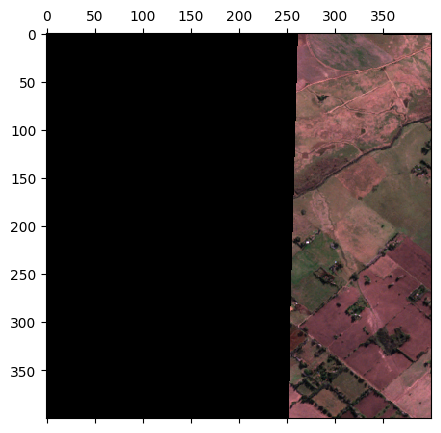

In [11]:
from matplotlib import pyplot as plt

colors_mins = chip.reshape(-1, chip.shape[-1]).min(axis=0)
colors_maxs = chip.reshape(-1, chip.shape[-1]).max(axis=0)
chip_normalized = (chip - colors_mins) / (colors_maxs - colors_mins)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(chip_normalized)
plt.show()

In [12]:
from rastervision.core.data import (
    ClassConfig, ClassInferenceTransformer, GeoJSONVectorSource,
    RasterizedSource, Scene)

class_config = ClassConfig(
    names=['background', 'asentamiento'],
    colors=['lightgray', 'darkred'],
    null_class='background')

class_inf_tf = ClassInferenceTransformer(
    default_class_id=class_config.get_class_id('asentamiento'))

vector_source = GeoJSONVectorSource(
    annotations_val,
    crs_transformer=raster_source.crs_transformer,
    vector_transformers=[class_inf_tf])

label_raster_source = RasterizedSource(
    vector_source=vector_source,
    background_class_id=class_config.null_class_id,
    bbox=raster_source.bbox)

In [13]:
from rastervision.core.data.utils import make_ss_scene

scene = make_ss_scene(
    class_config=class_config,
    image_uri=images_val,
    label_vector_uri=annotations_val,
    label_vector_default_class_id=class_config.get_class_id('asentamiento'),
    image_raster_source_kw=dict(allow_streaming=True))

In [14]:
%env AWS_NO_SIGN_REQUEST=YES

env: AWS_NO_SIGN_REQUEST=YES


In [15]:
image_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/images/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif'
label_uri = 's3://spacenet-dataset/spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson'
from rastervision.core.data import ClassConfig
from rastervision.pytorch_learner import (
    SemanticSegmentationSlidingWindowGeoDataset, SemanticSegmentationVisualizer)

import albumentations as A

class_config = ClassConfig(
    names=['background', 'building'],
    colors=['lightgray', 'darkred'],
    null_class='background')

ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    label_vector_uri=label_uri,
    label_vector_default_class_id=class_config.get_class_id('building'),
    image_raster_source_kw=dict(allow_streaming=True),
    size=200,
    stride=200,
    out_size=256,
)

x, y = ds[0]
x.shape, y.shape

2024-10-07 17:46:12:rastervision.pipeline.file_system.utils: INFO - Using cached file C:\Users\oltie\AppData\Local\Temp\cache\s3\spacenet-dataset\spacenet/SN7_buildings/train/L15-0331E-1257N_1327_3160_13/labels/global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13_Buildings.geojson.


RuntimeError: Numpy is not available

In [17]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    aoi_uri=AoI_file_dest,
    image_uri=images_val,
    label_vector_uri=annotations_val,
    label_vector_default_class_id=class_config.get_class_id('building'),
    image_raster_source_kw=dict(allow_streaming=True), #, raster_transformers=[MinMaxTransformer()]
    size=window_size,
    stride=window_size,
    # transform=A.Resize(window_size, window_size),
    out_size=window_size)

In [18]:
len(val_ds)

158

In [14]:
x, y = val_ds[0]
x = x.astype(int)
y = y.astype(int)

NameError: name 'val_ds' is not defined

In [20]:
vis = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

x, y = val_ds[0]

vis.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
# Aquí definimos cuantos recortes sobre la imagen tomaremos al azar
# idealmente, varias veces la cantidad de recortes en el dataset de validación
# (algo así como sample_size = len(val_ds) * 5
# pero como estos datos son "pesados" vamos a limitarnos a tomar una muestra de la misma cantidad
sample_size = len(val_ds)*5

train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    # aoi_uri=AoI_file_dest,
    image_uri=images_train,
    label_vector_uri=annotations_train,
    label_vector_default_class_id=class_config.get_class_id('asentamiento informal'),
    image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
    # window sizes will randomly vary from 100x100 to 300x300
    #size_lims=(100, 300),
    # fixed window size
    size_lims=(window_size, window_size+1),
    # resize chips before returning
    out_size=window_size,
    # allow windows to overflow the extent by 100 pixels
    padding=100,
    max_windows=sample_size, # pero como estos datos son "pesados" vamos a limitarnos a tomar una muestra de la misma cantidad
    transform=data_augmentation_transform
)

In [ ]:
x, y = vis.get_batch(train_ds, 8)

vis.plot_batch(x, y, show=True)

In [ ]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(window_size, window_size),
    pretrained=True)


In [ ]:
learner.train(epochs=n_epochs)

In [ ]:
learner.save_model_bundle()